#  Проект по построению модели прогнозирования остатков на расчетных счетах физических лиц

## Введение

**Вводные данные проекта:**

**Заказчик:** казначейство Сбербанка.

**Цель проекта:** построить модель, которая прогнозирует объем стабильной части средств на дату.

**Дополнительные условия заказчика:**
- Критерии качества модели - нужно одновременно минимизировать величины:
    - максимальный объем пробития стабильной части на валидационной выборке; 
    - фактическая стабильная часть – модельная стабильная часть; 


**Данные для анализа и построения модели:** подневные данные объема расчетных счетов физических лиц за период 30.12.2013 - 10.10.2019 гг.

**Этапы проекта:**

1. Загрузить, проанализировать данные и подготовить их к обучению (создать дополнительные признаки).
2. Осуществить подбор параметров для лучших моделей и выбрать одну для тестирования.
3. Протестировать модель.
4. Сделать выводы по результатам проекта.

## Загрузка и подготовка данных

In [1]:
# необходимые библиотеки
import warnings

# для работы с данными (предобработка, исследовательский анализ)
import pandas as pd
import numpy as np
from skimpy import clean_columns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import time

# для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# для машинного обучения
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from prophet import Prophet
from catboost import CatBoostRegressor
import lightgbm as ltb
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.dummy import DummyRegressor


# Отключаем предупреждения
warnings.filterwarnings("ignore")

In [2]:
# константа
SEED = 12345
TEST_SIZE = 0.1

In [3]:
# загрузка данных
data = pd.read_csv('ВС DS Сбер data.csv', sep=';')

In [4]:
data.head()

,REPORTDATE,VALUE
0,30.12.2013,3457625638
1,31.12.2013,3417092149
2,01.01.2014,3417092149
3,02.01.2014,3417092149
4,03.01.2014,3417092149


In [5]:
# приведем данные к snake_case
data = clean_columns(data)
data.head(3)

2 column names have been cleaned

,reportdate,value
0,30.12.2013,3457625638
1,31.12.2013,3417092149
2,01.01.2014,3417092149


Посмотрим общую информацию о данных.

In [6]:
def info_all(data):
    '''функция оценивает общую информацию о данных'''
    print('-'*50)
    print('Общая информация о данных')
    temp = data.copy() 
    list_c = data.columns
    print(temp.info())
    for col_l in list_c:
        print('-'* 25)
        print(col_l, temp[col_l].sort_values().unique())
        print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')
    print('-'*50)    
    display(data.describe()) 
    print('-'*50) 
    print('Поиск дубликатов')
    if data.duplicated().sum() == 0:
        print('Дубликаты по строкам отсутствуют')
    else:
        print('Количество дублирующихся строк:', data.duplicated().sum())
        display(data.loc[data.duplicated() == True])

In [7]:
# посмотрим общую информацию о данных
info_all(data)

--------------------------------------------------
Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reportdate  2111 non-null   object
 1   value       2111 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 33.1+ KB
None
-------------------------
reportdate ['01.01.2014' '01.01.2015' '01.01.2016' ... '31.12.2016' '31.12.2017'
 '31.12.2018']
reportdate : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
value [ 3282809762  3300717238  3305963251 ... 76917198439 78227602768
 78228598454]
value : кол-во NaN 0 , процент NaN 0.0 %
--------------------------------------------------


,value
count,2.111000e+03
mean,3.389668e+10
std,1.875474e+10
min,3.282810e+09
25%,1.824160e+10
50%,3.021352e+10
75%,4.758339e+10
max,7.822860e+10


--------------------------------------------------
Поиск дубликатов
Дубликаты по строкам отсутствуют


Данные представляют собой временной ряд. 

Пропуски и дубликаты отсутствуют. Необходимо преобразовать дату к нужному формату.

In [8]:
# приведем дату к нужному формату и установим ее в качестве индекса
data['reportdate'] = pd.to_datetime(data['reportdate'], format='%d.%m.%Y', dayfirst=True)
print(data.info())
data = data.set_index('reportdate')
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   reportdate  2111 non-null   datetime64[ns]
 1   value       2111 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 33.1 KB
None


,value
reportdate,
2013-12-30,3457625638
2013-12-31,3417092149
2014-01-01,3417092149
2014-01-02,3417092149
2014-01-03,3417092149


Отсортируем данные по индексу и проверим временной ряд на монотонность.

In [9]:
data = data.sort_index()

In [10]:
if data.index.is_monotonic == True:
    print('Временной ряд монотонный')
else:
    print('Временной ряд не монотонный')

Временной ряд монотонный


Построим график распределение объемов остатков на р/с ФЛ.

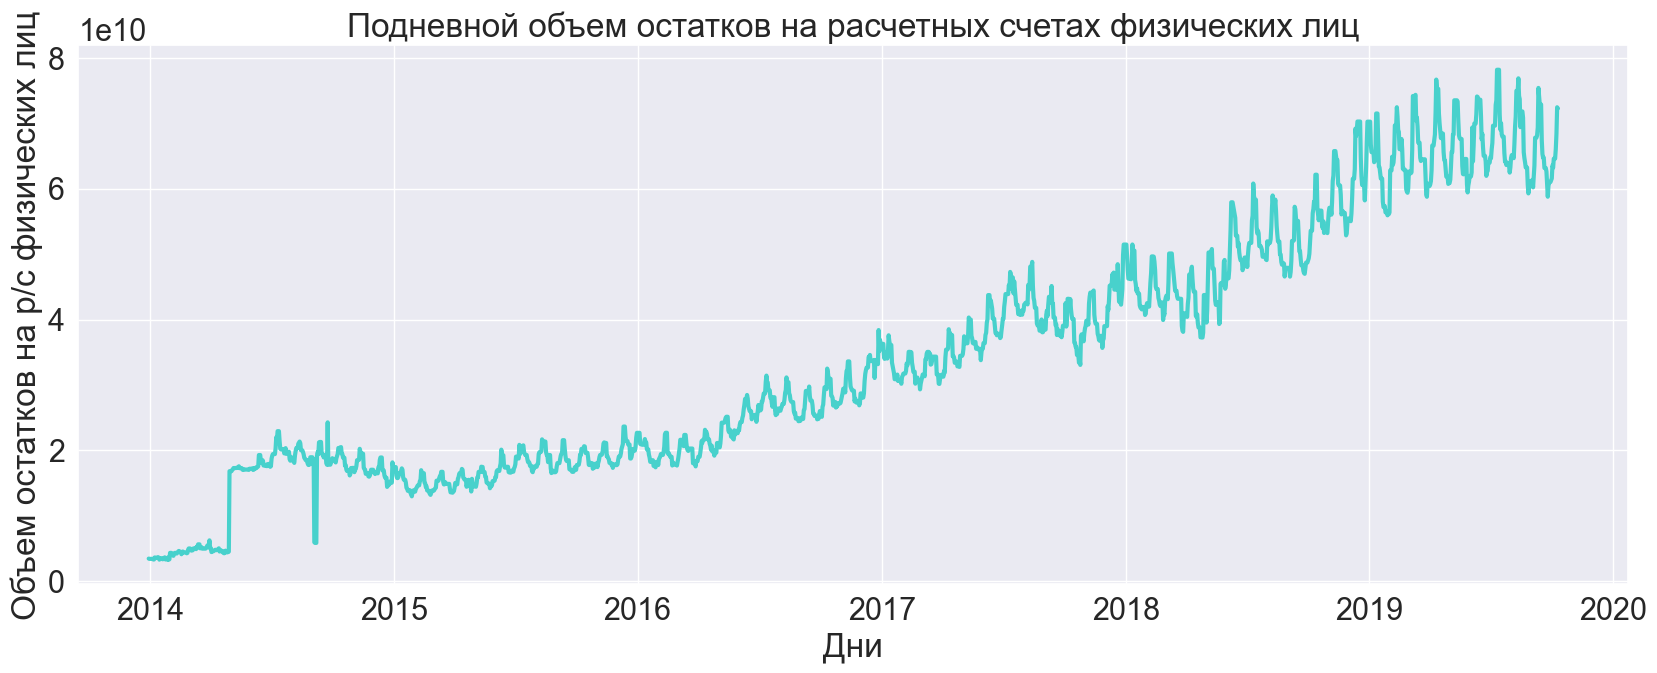

In [11]:
sns.set(font_scale= 2)
fig, ax = plt.subplots(figsize=(20,7))
plt.title('Подневной объем остатков на расчетных счетах физических лиц')
ax.set(xlabel='Дни', ylabel='Объем остатков на р/с физических лиц')
ax.plot(data.index, data['value'], linewidth=3, color='mediumturquoise')
plt.show()

Видим, что тенденция положительная - объем привлеченных средств на расчетных счетах физических лиц растет на протяжении анализируемого периода. 

Видим, что в период с 2014 по 2015 гг. были нетипичные колебания, поэтому возьмем период с 2015 по текущий год (2019).

In [12]:
data = data.query("'2015-01-05' <= @data.index")
data.head()

,value
reportdate,
2015-01-05,16162817600
2015-01-06,15775433202
2015-01-07,15775433202
2015-01-08,16010735177
2015-01-09,16505141860


Переведем значения value в млн. руб. для лучшего визуального восприятия данных:

In [13]:
data = data/1000000

Перед началом аналитической части проверим наш временной ряд на стационарность. Для этого проведем обобщенный тест Дикки-Фуллера на наличие единичных корней. Воспользуемся модулем statsmodels, функцией adfuller():

In [14]:
result = adfuller(data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0]> result[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')    

ADF Statistic: 0.067994
p-value: 0.963807
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
есть единичные корни, ряд не стационарен


Ряд не стационарен, при построении моделей необходимо это учесть.

**Выводы по результатам подготовки данных к анализу:**
1. При оценке общей информации о данных не обнаружено пропусков и дубликатов.
2. Проведены следующие этапы подготовки данных:
    - дата преобразована в необходимый формат и присвоена в качестве индекса;
    - временной ряд отсортирован и проверен на стационарность (проведен обобщенный тест Дикки-Фуллера на наличие единичных корней).

## Исследовательский анализ данных

Посмотрим диаграмму размаха по объему привлеченных средств ФЛ на р/с.

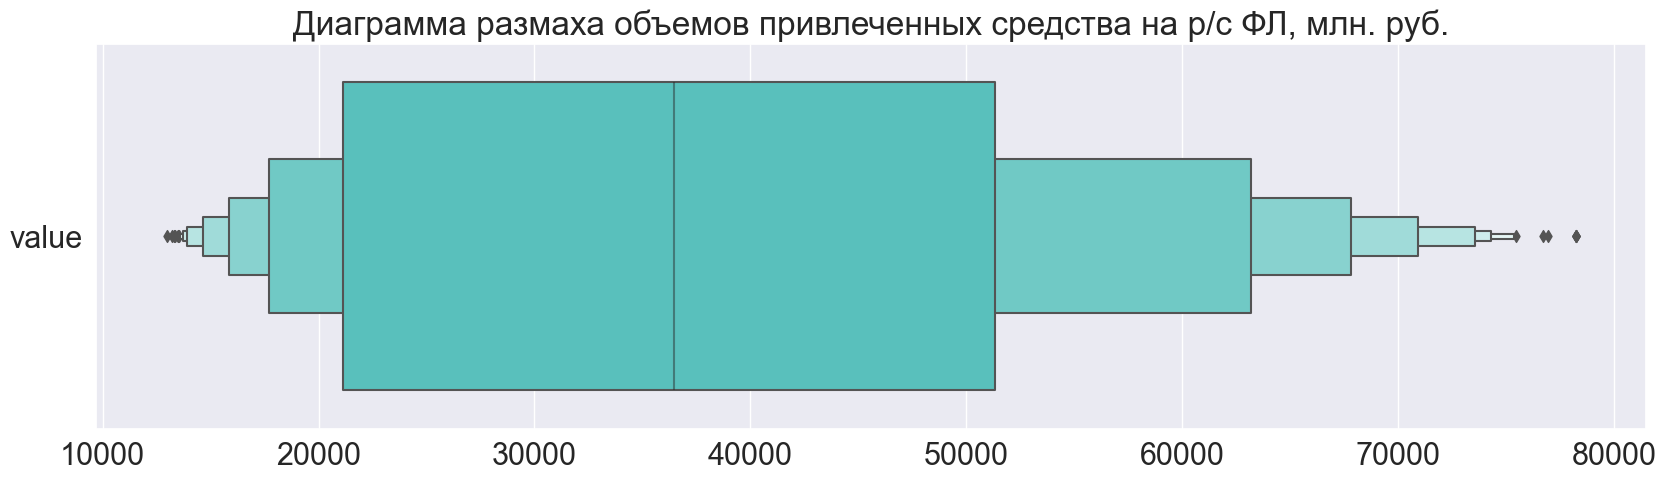

In [15]:
fig, ax = plt.subplots(figsize = (20,5))
ax = sns.boxenplot(data=data, orient='h', color='mediumturquoise')
ax.set_title('Диаграмма размаха объемов привлеченных средства на р/с ФЛ, млн. руб.')
plt.show()

При анализе боксплота видим, что выбросы/аномальные значения отсутствуют.

Посмотрим тренды и сезонность.

In [16]:
decomposed = seasonal_decompose(data) 

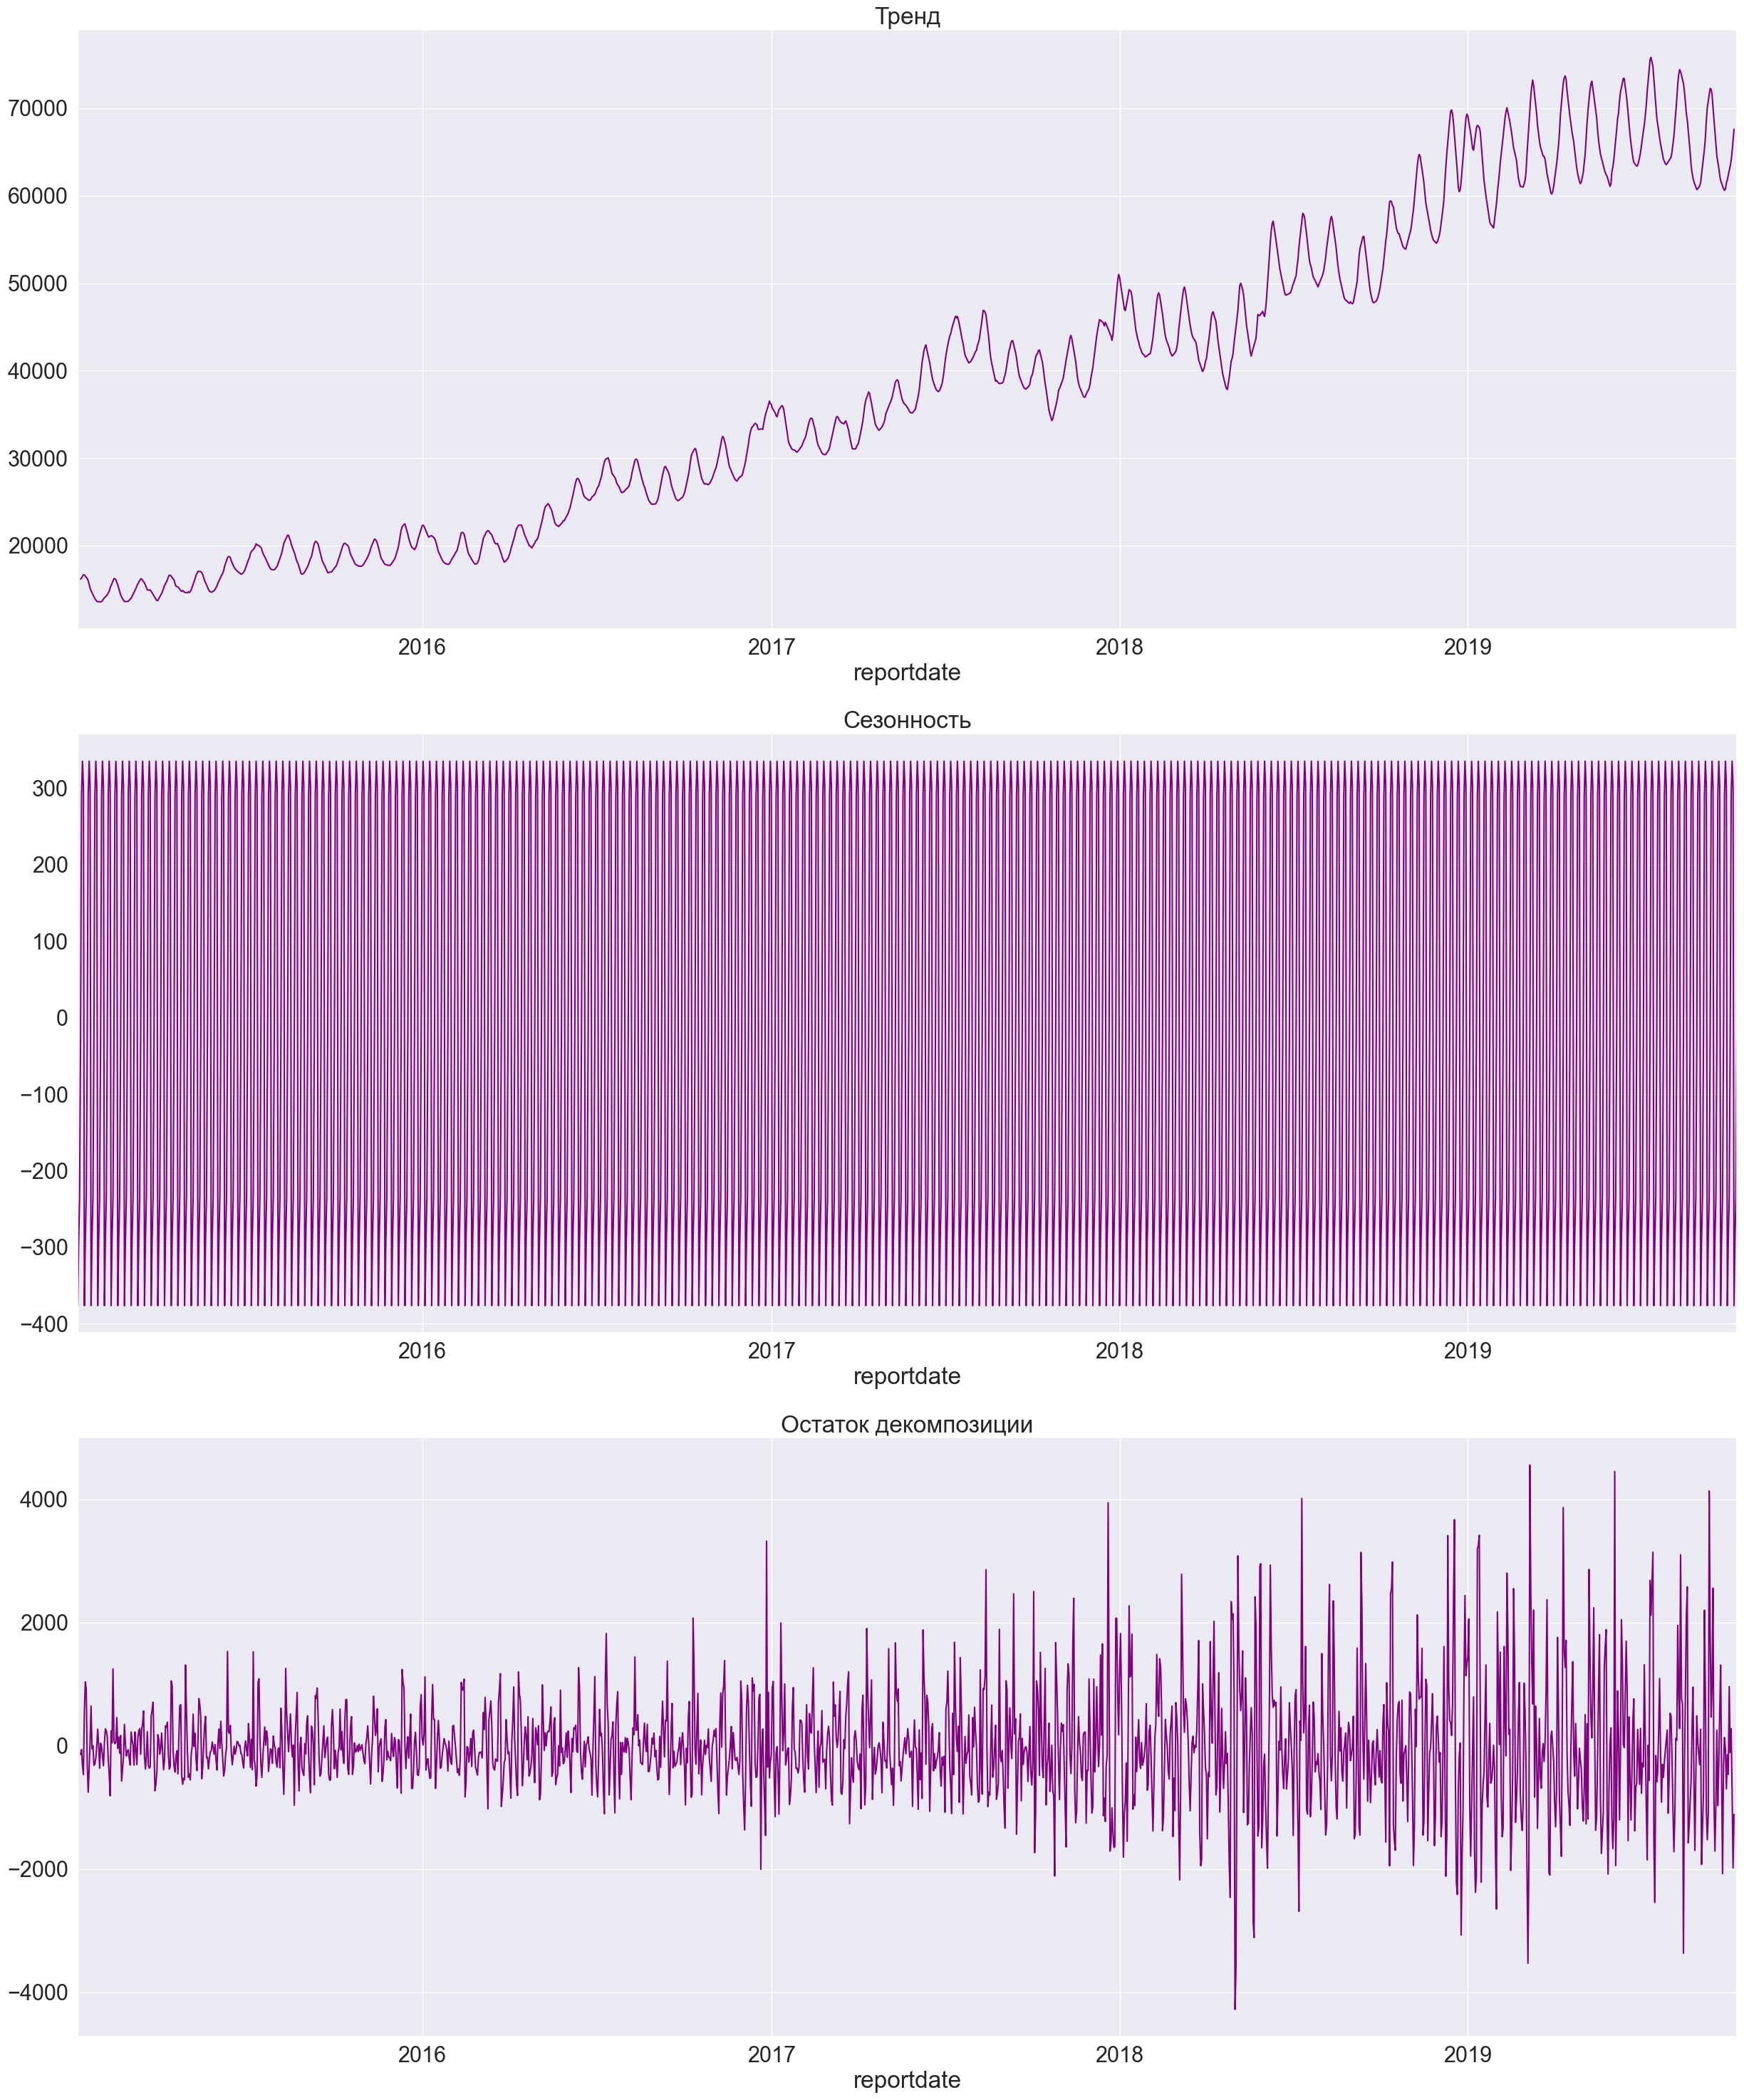

In [17]:
fig, ax = plt.subplots(figsize=(25,30))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), color='purple')
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), color='purple')
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), color='purple')
plt.title('Остаток декомпозиции')
plt.tight_layout()

На графике тренда видим тенденцию к росту привлеченных средств в течение всего анализируемого периода, особенно динамичный рост наблюдается в 2018 году. 
Также можно увидеть, что периодически происходят всплески в сторону увеличения и уменьшения объемов средств.

`Временной ряд имеет экспоненциальный тренд, мультипликативную сезонность.`

Построим график сезонной составляющей за несколько последних полных недель - с 23.09.2019 по 06.10.2019:

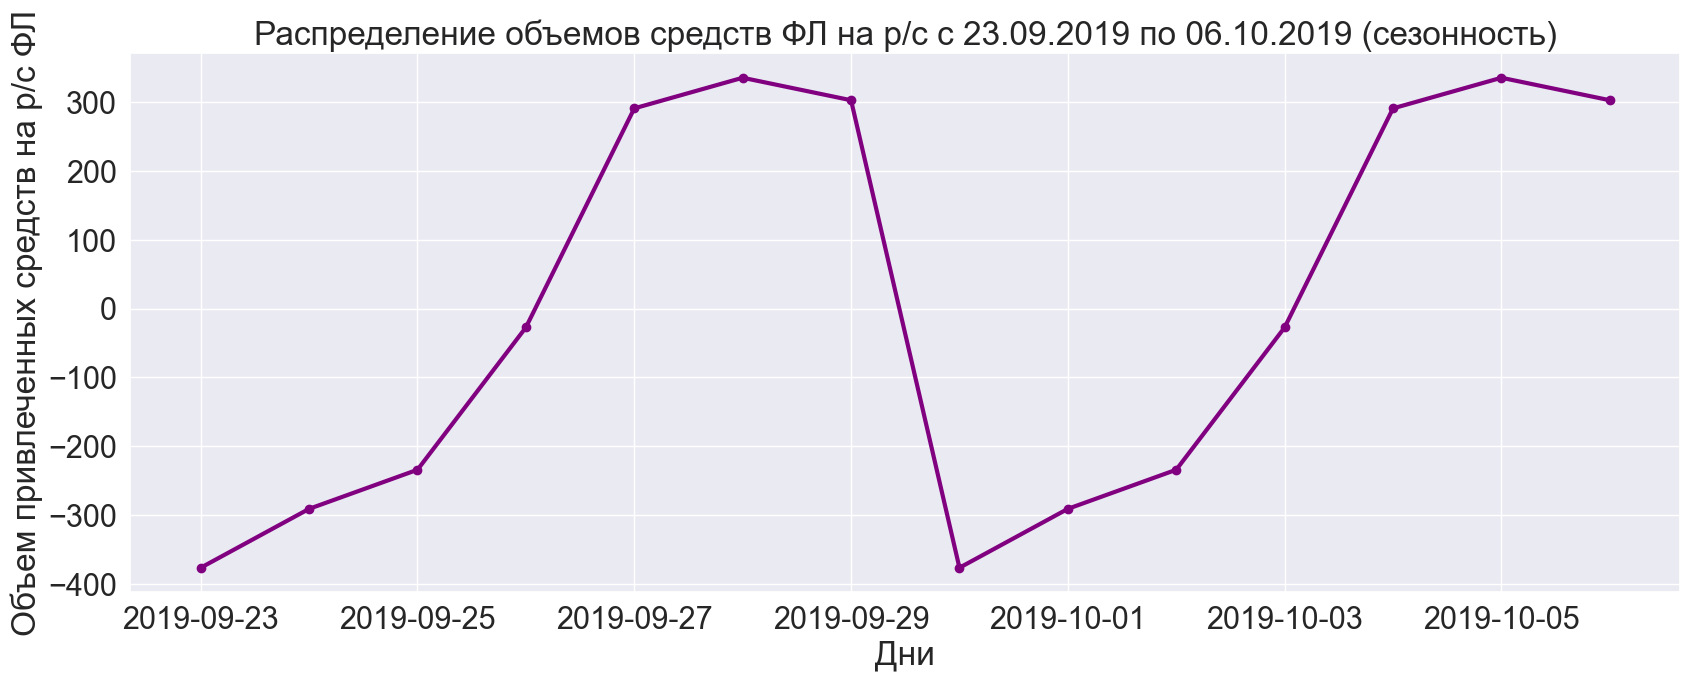

In [18]:
fig, ax = plt.subplots(figsize=(20,7))
plt.title('Распределение объемов средств ФЛ на р/с с 23.09.2019 по 06.10.2019 (сезонность)')
ax.set(xlabel='Дни', ylabel='Объем привлеченных средств на р/с ФЛ')
ax.plot(decomposed.seasonal['2019-09-23':'2019-10-06'].index, decomposed.seasonal['2019-09-23':'2019-10-06'], 
        linewidth=3, color='purple', marker='o')
plt.show()

Если оценить календарные даты с точки зрения дней недели, то можно заметить, что **пик объема ресурсов приходится на пятницу, субботу и воскресенье, с резким спадом в понедельник.**

**Выводы по исследовательскому анализу данных:**
1. В ходе исследовательского анализа данных оценена сезонность и тренды:
    - выявлена тенденция к росту объемов средств на р/с ФЛ в течение всего анализируемого периода, особенно в последние годы (2018 г);
    - сезонность отмечена еженедельная (цикличность увеличения объемов ресурсов на счетах с пятницы по воскресенье с резким спадом по понедельникам).

### Метрики качества

Метрики качества модели:
- `максимальный объем пробития стабильной части` на валидационной выборке;

Для учета объема пробития при построении модели возьмем положительные значения разницы между predict и target и рассчитаем среднее. Таким образом, мы получим средний объем отклонения наших предсказаний от реальных остатков при условии, что объем оттока средств (target) будет уходить ниже значения, которое мы спрогнозировали (predict).

- `фактическая стабильная часть` – модельная стабильная часть;

Будем уменьшать среднеквадратическую ошибку (RMSE), что позволит максимально приблизить предсказания к реальным объемам остатков на р/с ФЛ.

Создадим 2 метрики и объединим их в одну:

In [19]:
def rmse(target, predict):
    '''RMSE'''
    mse = mean_squared_error(target, predict)
    return mse**0.5
rmse_score = make_scorer(rmse, greater_is_better=False)

In [20]:
def dev(target, predict):
    '''объем пробития стабильной части'''
    target = target[: len(predict)]
    predict = np.array(predict)
    target = np.array(target)
    deviation = pd.Series(predict - target)
    mean_deviation = deviation[deviation > 0].mean()
    return mean_deviation

deviation_score = make_scorer(dev, greater_is_better=False)

In [21]:
def combo(target, predict):
    '''объединение 2-х метрик: отклонение объема пробития стабильной части и RMSE '''
    score = rmse(target, predict) + dev(target, predict)
    return score

combo_score = make_scorer(combo, greater_is_better=False)

### Добавление новых признаков и деление на выборки

In [22]:
def code_mean(data, cat_feature, real_feature):
    '''возвращает уникальные категории признака cat_feature и средние по real_feature'''
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [23]:
def make_features(data, lag_start=3, lag_end=7, test_size=TEST_SIZE):  #rolling_mean_size,
    '''создает дополнительные признаки для временного ряда и делит на выборки'''
 
    data_features = data.copy()
    data_features.columns = ["y"]
  
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data) * (1 - test_size))
    
    # создаем доп признаки
    data_features["weekday"] = data_features.index.weekday
    data_features["week_peaks"] = (data_features.weekday.isin([4,5, 6]) * 1).astype('category')
        
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data_features["lag_{}".format(i)] = data_features.y.shift(i)
        
    # считаем средние и находим пик только по тренировочной части, чтобы избежать утечки
    data_features["weekday_average"] = list(
        map(code_mean(data_features[:test_index], "weekday", "y").get, data_features.weekday))
    
    # удаляем ненужные признаки и пропуски
    data_features.drop([ "weekday"], axis=1, inplace=True)
    data_features = data_features.dropna()
    data_features = data_features.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    features_train = data_features.loc[:test_index].drop(["y"], axis=1)
    target_train = data_features.loc[:test_index]["y"]
    features_test = data_features.loc[test_index:].drop(["y"], axis=1)
    target_test = data_features.loc[test_index:]["y"]

    return features_train, target_train, features_test, target_test

In [24]:
features_train, target_train, features_test, target_test = make_features(data, lag_start=3, lag_end=8, test_size=0.1)

In [25]:
features_train.shape, target_train.shape, features_test.shape, target_test.shape

((1567, 7), (1567,), (167, 7), (167,))

In [26]:
features_train.head()

,week_peaks,lag_3,lag_4,lag_5,lag_6,lag_7,weekday_average
0,0,16505.141860,16010.735177,15775.433202,15775.433202,16162.817600,34633.566113
1,0,16505.141860,16505.141860,16010.735177,15775.433202,15775.433202,34820.688587
2,0,16505.141860,16505.141860,16505.141860,16010.735177,15775.433202,34852.999182
3,0,16856.140534,16505.141860,16505.141860,16505.141860,16010.735177,35098.349080
4,1,17258.793498,16856.140534,16505.141860,16505.141860,16505.141860,35396.964020


Визуализируем деление на выборки:

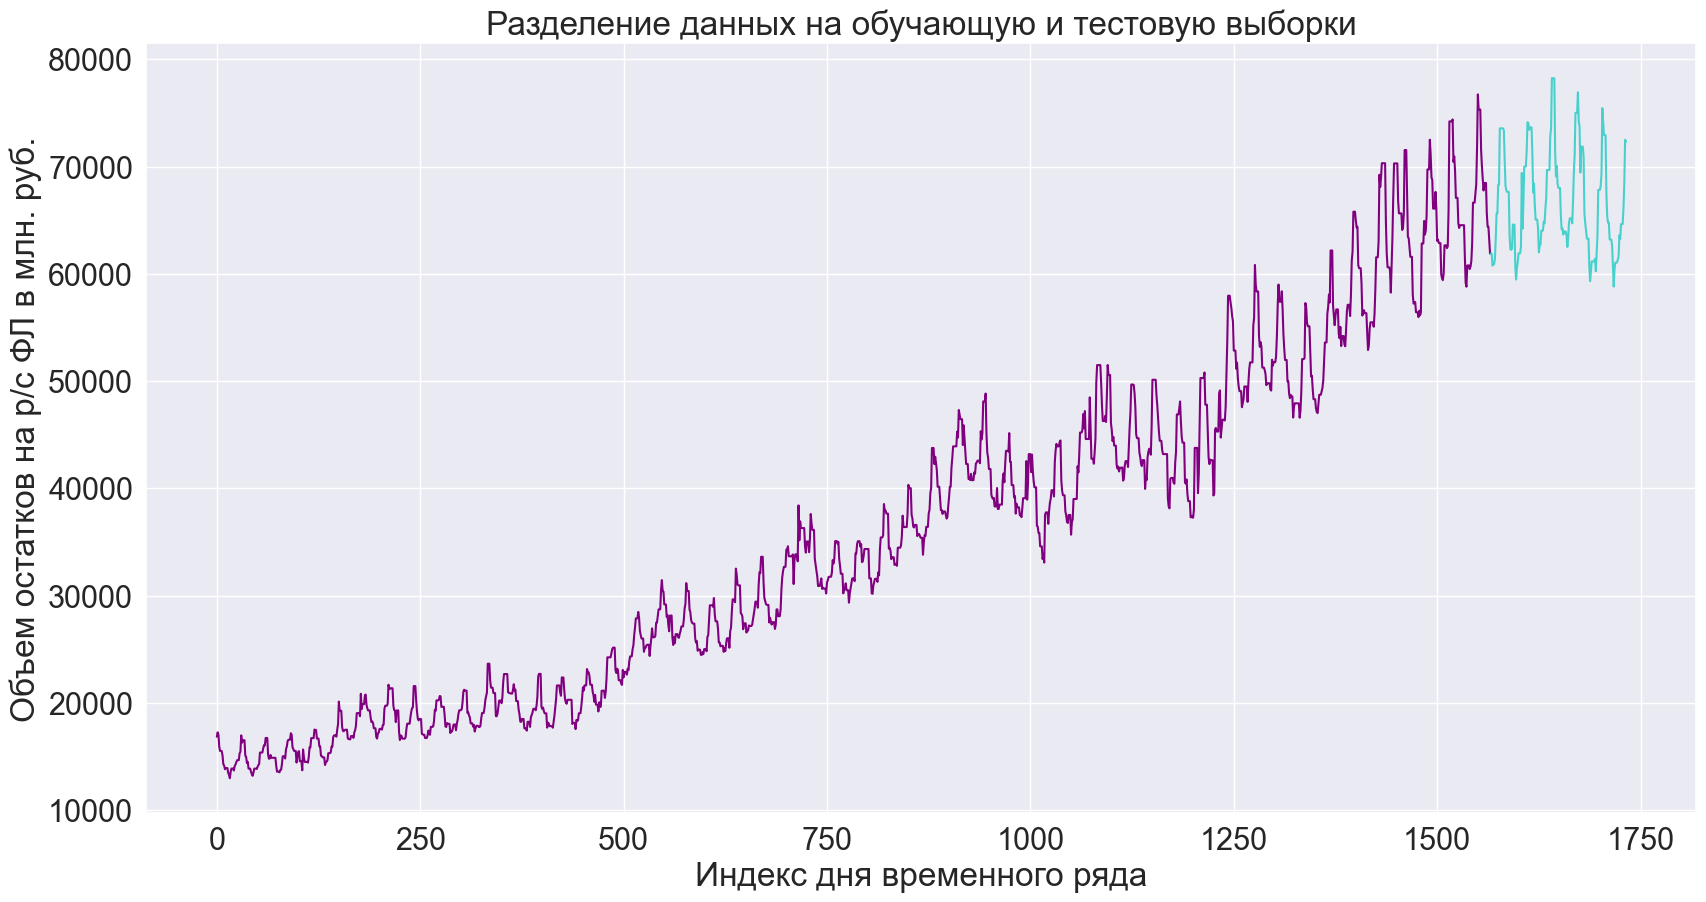

In [27]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(target_train, color = "purple")
plt.plot(target_test, color = 'mediumturquoise')
plt.title('Разделение данных на обучающую и тестовую выборки')
plt.ylabel('Объем остатков на р/с ФЛ в млн. руб.')
plt.xlabel('Индекс дня временного ряда')
plt.show()

## Обучение моделей

### Подбор гиперпараметров моделей

In [28]:
# создадим функции для подбора параметров
# целевой метрикой качества выберем кастомную метрику combo_score
def gridsearch (model, params, features_train, target_train):
    '''подбирает гиперпараметры к модели с помощью GridSearchCV'''
    time_cv = TimeSeriesSplit(n_splits = 3)
    grid = GridSearchCV(model, params, n_jobs=-1, scoring=combo_score, cv=time_cv, verbose = False)
    grid.fit(features_train, target_train)
    print('Лучшие параметры модели:', grid.best_params_)
    print(f'{model}','combo: {:.2f}'.format(grid.best_score_))
    return grid

In [29]:
#категориальные признаки
ohe_features = features_train.select_dtypes(include=['category', 'object']).columns.to_list()
ohe_features

['week_peaks']

In [30]:
#численные признаки
num_features = features_train.select_dtypes(exclude=['category', 'object']).columns.to_list()
num_features

['lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'weekday_average']

In [31]:
# трансформеры
col_transformer_lr = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore'), ohe_features),
    (StandardScaler(), num_features),
    verbose_feature_names_out=False)

Приступаем к подбору гиперпараметров моделей.

In [32]:
cb_params = {'iterations': [100, 1000],
            'learning_rate': [0.01, 0.03, 0.1],
            'depth': [6, 8],
            'l2_leaf_reg': [1, 3],
            'logging_level': ['Silent'],
            'custom_metric':['RMSE']}

lgbm_params = {'n_estimators':[100, 200, 400, 700, 1000],
               'learning_rate': [0.1, 0.25, 0.5],
               'max_depth': [5, 10, 15, 20],
              'objective': ['RMSE']}

ridge_params = {'ridge__alpha':[0.1, 100],
               'ridge__fit_intercept' : [True, False],
               'ridge__max_iter' : [100, 200, 400, 700, 1000, 1500],
               'ridge__solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']}

Перед тем, как мы начнем обучение моделей, создадим константную модель (dummy), которая предсказывает среднее значение. Это позволит проводить сравнительную оценку метрик качества моделей. Будем сравнивать универсальную метрику RMSE.

In [33]:
# создаем и обучаем модель со средним значением целевого признака
dummy_clf = DummyRegressor(strategy='mean')
dummy_clf.fit(features_train, target_train)
predictions_test = dummy_clf.predict(features_test)
rmse_dummy = rmse(target_test, predictions_test)
combo_dummy = combo(target_test, predictions_test)
dev_dummy = dev( target_test, predictions_test)
print("RMSE на тестовой выборке: %.2f" % rmse_dummy)

RMSE на тестовой выборке: 31806.66


Для моделей catboost и lgbm предобработка признаков не требуется (кодирование, шкалирование). Обучим модели и сохраним лучшую.

#### CatBoostRegressor

In [34]:
%%time
cb_grid = gridsearch(CatBoostRegressor(cat_features=ohe_features, random_state=SEED), cb_params, features_train, target_train)

Лучшие параметры модели: {'custom_metric': 'RMSE', 'depth': 8, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'logging_level': 'Silent'}
<catboost.core.CatBoostRegressor object at 0x0000024520158CD0> combo: -10243.14
CPU times: total: 2.41 s
Wall time: 1min 47s


In [35]:
# сохраняем лучшую модель
cb_grid = cb_grid.best_estimator_

#### LGBMRegressor

In [36]:
%%time
lgbm_grid = gridsearch(LGBMRegressor(random_state=SEED), lgbm_params, features_train, target_train)

Лучшие параметры модели: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 100, 'objective': 'RMSE'}
LGBMRegressor(random_state=12345) combo: -10705.69
CPU times: total: 1.41 s
Wall time: 34.4 s


In [37]:
# сохраняем лучшую модель
lgbm_grid = lgbm_grid.best_estimator_

#### Ridge

Для данной модели необходимо провести предварительную подготовку признаков. Воспользуемся ранее созданным трансформером, который обработает категориальный столбец и выполнить шкалирование количественных признаков:

In [38]:
model_r = Ridge(random_state=SEED)
pipeline_r = make_pipeline(col_transformer_lr, model_r)

In [39]:
%%time
r_grid = gridsearch(pipeline_r, ridge_params, features_train, target_train)

Лучшие параметры модели: {'ridge__alpha': 0.1, 'ridge__fit_intercept': True, 'ridge__max_iter': 100, 'ridge__solver': 'sag'}
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['week_peaks']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['lag_3', 'lag_4', 'lag_5',
                                                   'lag_6', 'lag_7',
                                                   'weekday_average'])],
                                   verbose_feature_names_out=False)),
                ('ridge', Ridge(random_state=12345))]) combo: -3953.33
CPU times: total: 1.86 s
Wall time: 5.

In [40]:
r_grid = r_grid.best_estimator_

#### Prophet

Профит является специализированным инструментом для моделирования временных рядов. Модель имеет свои особенности, поэтому для нее подготовим специальную выборку для обучения:

In [41]:
# готовим выборки для обучения
data_features = data.copy()
data_features.columns = ['y']
test_index = int(len(data) * (1 - TEST_SIZE))
data_features['ds'] = data_features.index
data_features = data_features.reset_index(drop=True)

features_train_pr = data_features.loc[:test_index]
features_test_pr = data_features.loc[test_index:]
features_train_pr.head(3)

,y,ds
0,16162.817600,2015-01-05
1,15775.433202,2015-01-06
2,15775.433202,2015-01-07


In [42]:
# обучаем модель на тренировочных данных
prophet = Prophet(growth='linear', changepoints=None,
                  n_changepoints=120,
                  seasonality_mode='multiplicative',
                  yearly_seasonality= 'auto', 
                  weekly_seasonality='auto', 
                  daily_seasonality= 7,
                  holidays=None)
prophet.add_country_holidays(country_name='RU')
prophet.add_seasonality(name='monthly', period=30.5, fourier_order=3)

prophet.fit(features_train_pr)

00:23:24 - cmdstanpy - INFO - Chain [1] start processing
00:23:48 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
# получим прогноз
df_prophet = prophet.make_future_dataframe(periods=len(features_test_pr), freq='D', include_history=True)
df_prophet = prophet.predict(df_prophet)
display(df_prophet.head)

<bound method NDFrame.head of              ds         trend    yhat_lower    yhat_upper   trend_lower  \
0    2015-01-05   2068.698894  15150.507748  18484.946972   2068.698894   
1    2015-01-06   2068.542189  15003.884995  18722.631891   2068.542189   
2    2015-01-07   2068.385484  14524.500814  18054.812285   2068.385484   
3    2015-01-08   2068.228779  15256.890729  18951.241722   2068.228779   
4    2015-01-09   2068.072074  15434.233688  18916.453354   2068.072074   
...         ...           ...           ...           ...           ...   
1736 2019-10-07  11054.183569  69087.956331  82198.838642  10083.269483   
1737 2019-10-08  11062.973560  70469.675183  83711.964475  10085.336351   
1738 2019-10-09  11071.763551  71653.678410  85080.608779  10087.774376   
1739 2019-10-10  11080.553542  73535.311904  87916.326009  10092.400322   
1740 2019-10-11  11089.343532  75237.085443  90234.309118  10097.026269   

       trend_upper  Christmas Day  Christmas Day_lower  Christmas Day

(1450.0, 1750.0)

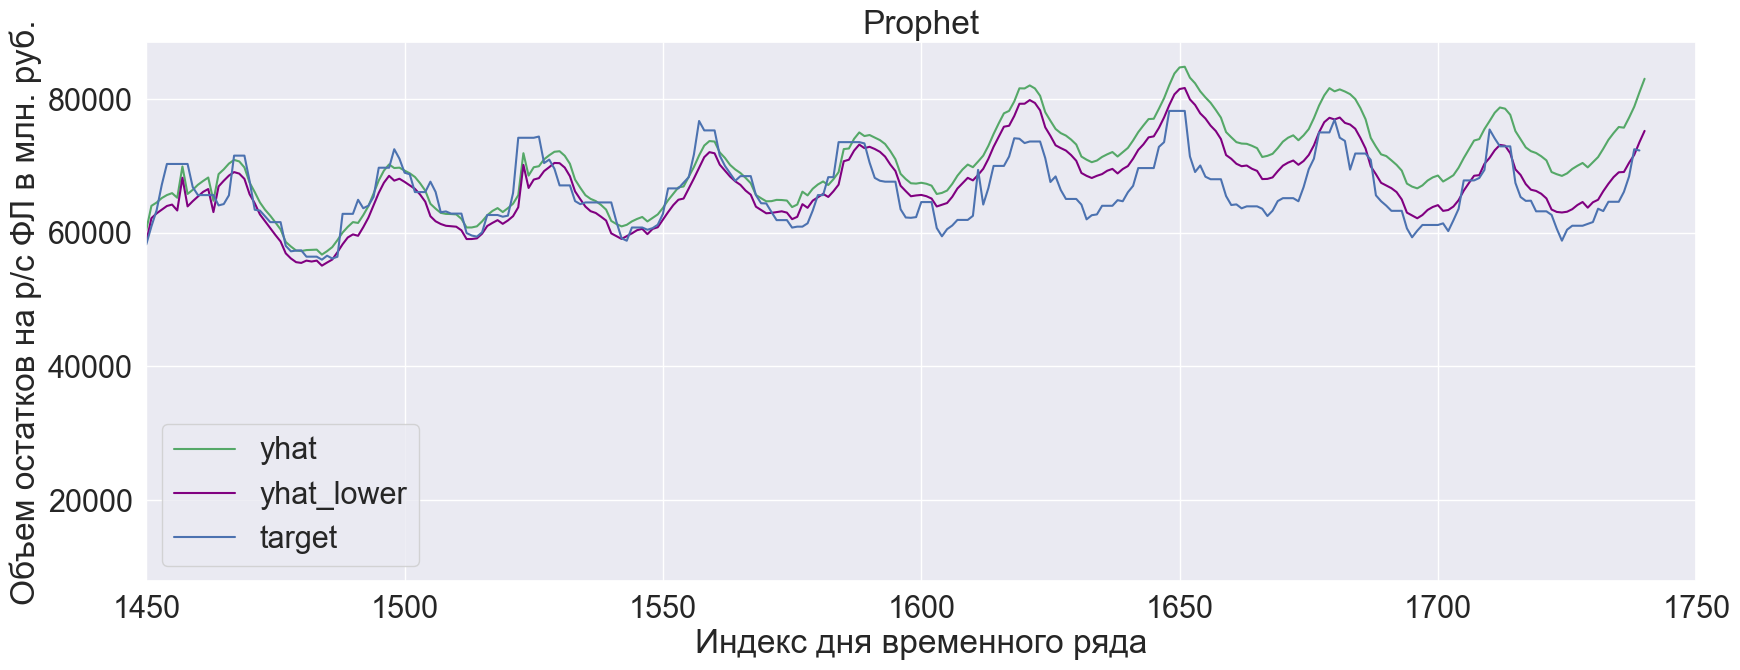

In [44]:
plt.figure(figsize=(20, 7))
plt.plot(df_prophet.yhat, "g", label="yhat")
plt.plot(df_prophet.yhat_lower, 'purple', label="yhat_lower")
plt.plot(data_features.y, 'b', label="target")
plt.legend(loc="best")
plt.ylabel('Объем остатков на р/с ФЛ в млн. руб.')
plt.xlabel('Индекс дня временного ряда')
plt.title( 'Prophet')
plt.xlim(1450, 1750)

К таргету ближе предсказание yhat_lower, воспользуемся им при оценке метрики на кросс-валидации.

### Оценка моделей с помощью кросс-валидации

Проверим модели с помощью кросс-валидации и посчитаем средний результат кастомной метрики combo.

In [45]:
%%time
grid_models = {}
grid_models['CatBoost'] = cb_grid
grid_models['LGBM'] = lgbm_grid
grid_models['Ridge'] = r_grid

tscv = TimeSeriesSplit(n_splits=7)
print(tscv)

results_combo = []
results_combo_mean = []

print('combo')

for key in grid_models:
    cv_result = cross_val_score(grid_models[key], features_train, target_train, cv=tscv, scoring = combo_score)
    results_combo.append(cv_result)
    results_combo_mean.append(np.abs(round(cv_result.mean(),2)))
    print('%s: %f (%f)' % (key, cv_result.mean(), cv_result.std()))

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=7, test_size=None)
combo
CatBoost: -5808.716754 (2659.130998)
LGBM: -6234.964251 (3042.009118)
Ridge: -3628.569644 (1499.726446)
CPU times: total: 15.2 s
Wall time: 7.63 s


Для prophet воспользуемся встроенной в библиотеку кросс-валидацией.

In [46]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(prophet, initial='365 days', period='30 days', horizon = '20 days') 

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/40 [00:00<?, ?it/s]

00:23:58 - cmdstanpy - INFO - Chain [1] start processing
00:23:59 - cmdstanpy - INFO - Chain [1] done processing
00:24:00 - cmdstanpy - INFO - Chain [1] start processing
00:24:00 - cmdstanpy - INFO - Chain [1] done processing
00:24:00 - cmdstanpy - INFO - Chain [1] start processing
00:24:00 - cmdstanpy - INFO - Chain [1] done processing
00:24:01 - cmdstanpy - INFO - Chain [1] start processing
00:24:01 - cmdstanpy - INFO - Chain [1] done processing
00:24:01 - cmdstanpy - INFO - Chain [1] start processing
00:24:02 - cmdstanpy - INFO - Chain [1] done processing
00:24:02 - cmdstanpy - INFO - Chain [1] start processing
00:24:02 - cmdstanpy - INFO - Chain [1] done processing
00:24:03 - cmdstanpy - INFO - Chain [1] start processing
00:24:03 - cmdstanpy - INFO - Chain [1] done processing
00:24:04 - cmdstanpy - INFO - Chain [1] start processing
00:24:05 - cmdstanpy - INFO - Chain [1] done processing
00:24:05 - cmdstanpy - INFO - Chain [1] start processing
00:24:08 - cmdstanpy - INFO - Chain [1]

In [47]:
results_combo_mean.append(round(combo(df_cv['y'], df_cv['yhat_lower']),2))

Посмотрим значения моделей после кросс-валидации по пользовательской метрике combo, которая объединяет значение RMSE и объема пробития стабильной части:

In [48]:
models_simile = pd.DataFrame(results_combo_mean, 
                                   columns=['Отклонения метрик объема пробития стабильной части и RMSE'], 
                                   index=['CatBoost','LGBM', 'Ridge', 'Prophet'])
models_simile.sort_values(by='Отклонения метрик объема пробития стабильной части и RMSE', ascending=True)

,Отклонения метрик объема пробития стабильной части и RMSE
Ridge,3628.57
Prophet,4597.18
CatBoost,5808.72
LGBM,6234.96


По итогам проверки моделей с помощью кросс-валидации модель Ridge показала самый низкий (лучший) показатель метрики из всех обученных моделей.
Протестируем модель на тестовой выборке.

## Тестирование выбранной модели

In [49]:
start_time = time.time()
y_pred_test = r_grid.fit(features_train, target_train).predict(features_test)
time_fit_pred = round((time.time() - start_time),2)
print('RMSE на тестовой выборке:', round(rmse(target_test, y_pred_test),2))
print('Объем пробития стабильной части на тестовой выборке',dev(target_test, y_pred_test))
print('Общее время обучения и предсказания:', time_fit_pred, 'секунд')

RMSE на тестовой выборке: 3441.3
Объем пробития стабильной части на тестовой выборке 2647.071843448136
Общее время обучения и предсказания: 0.02 секунд


In [50]:
# вернем в таргет и предсказание индексы в виде дат
data_test = data.tail(167).index
y_pred = pd.Series(y_pred_test, index=data_test)
target_t = pd.Series(target_test.array, index=data_test)

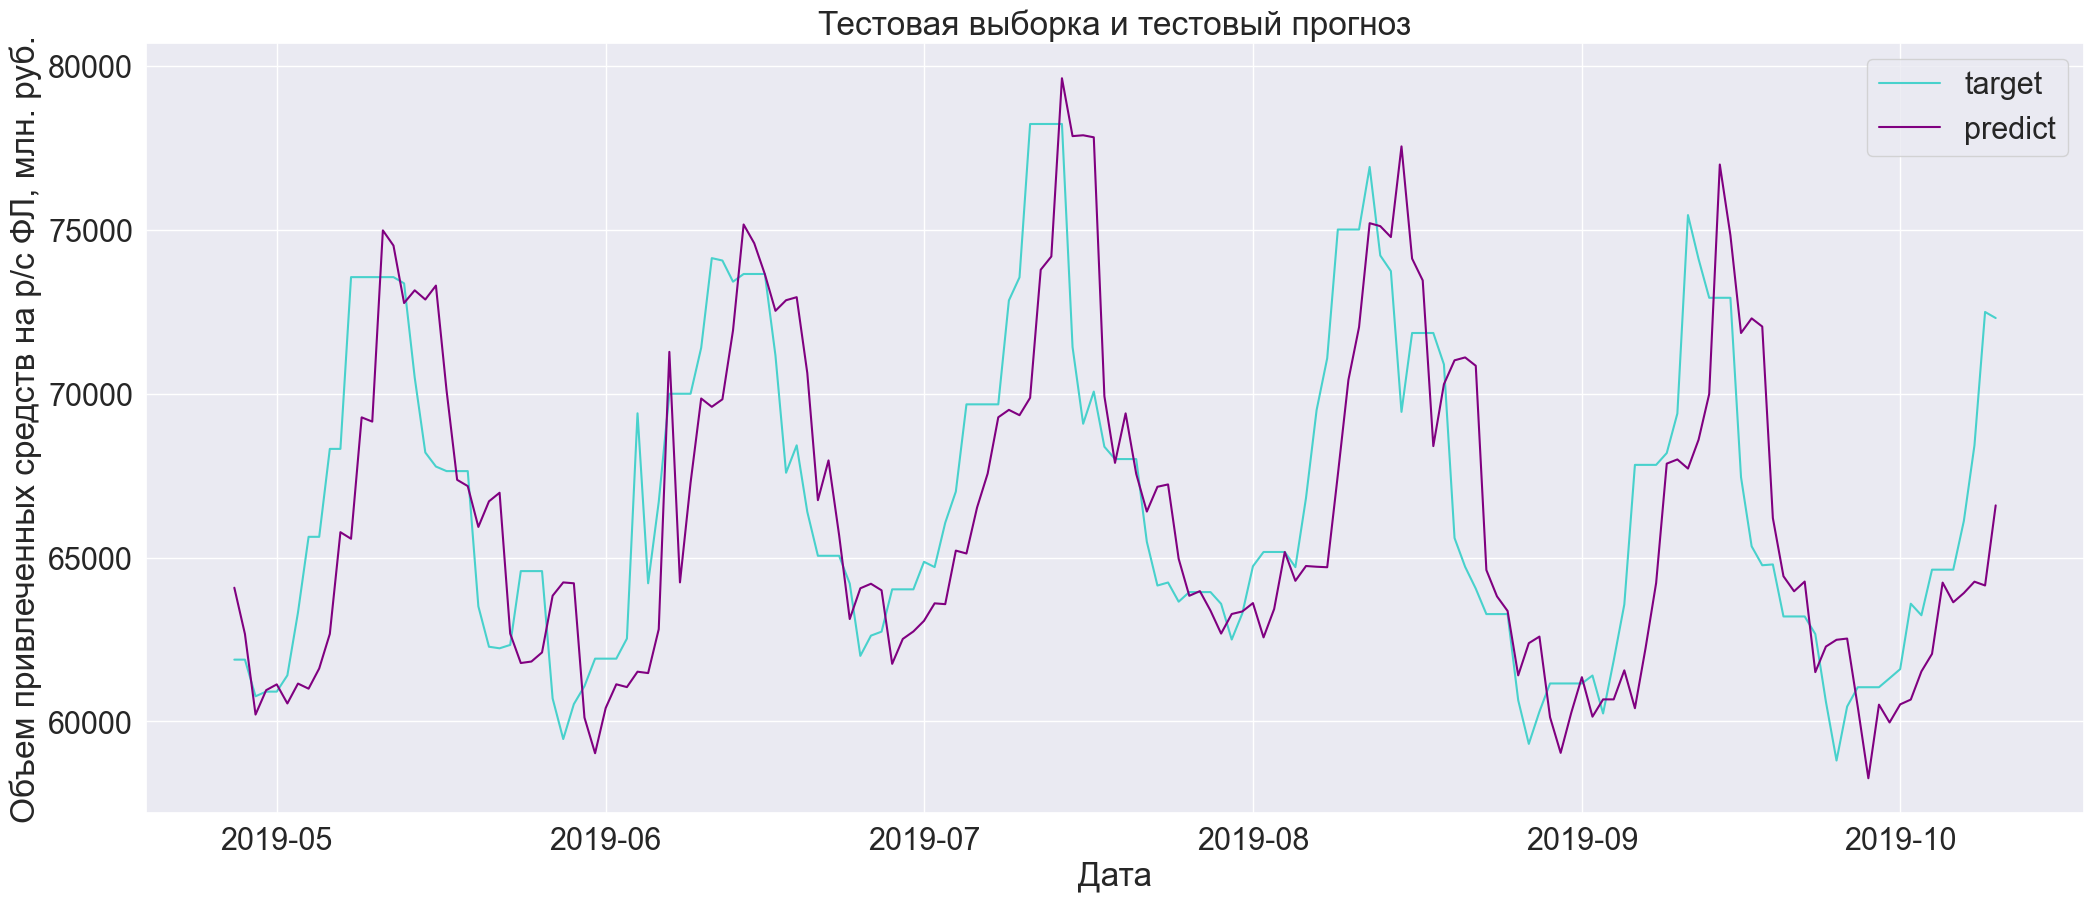

In [51]:
# отразим на графике тестовую выборку и тестовый прогноз
fig, ax = plt.subplots(figsize=(25,10))
plt.plot(target_t, color = "mediumturquoise", label="target")
plt.plot(y_pred, color = "purple", label="predict")
plt.legend(loc="best")
plt.title("Тестовая выборка и тестовый прогноз")
plt.ylabel('Объем привлеченных средств на р/с ФЛ, млн. руб.')
plt.xlabel('Дата')
plt.show()

На тестовой выборке получили достаточно неплохие результаты - модель предсказывает с точностью +-3441.3 млн. руб.

Обученная модель показывает RMSE (3441.3), что в 9 раза меньше, чем dummy модель (31806.66).

Средний объем пробития стабильной части на тестовой выборке с горизонтом 5-6 месяцев составляет 2647 млн. руб. (размер кастомной метрики dev).

## Выводы по результатам проекта

В ходе работы над проектом были выполнены следующие задачи:
- Проведена предобработка данных и подготовка их к построению модели.
- В ходе исследовательского анализа данных был `выявлен положительный тренд` в анализируемом временном ряду и `еженедельная цикличность (сезонность)` - максимальный объем ресурсов на счетах ФЛ достигается в пятницу, субботу и воскресенье.

Для прогнозирования использовались следующие модели ML:
- Ridge;	
- Prophet;
- CatBoostRegressor;
- LGBMRegressor.


`Лучшие результаты` по предсказанию объемов привлеченных средств физических лиц на расчетных счетах показала `модель Ridge` благодаря удачно подобранным синтетическим признакам. Неоспоримым `преимуществом данной модели` является `быстрота обучения` и `простота` построения.

Однако не следует исключать из перспективных моделей `Prophet`, так как при более точечном подборе гиперпараметров она может дать высокие результаты. Кроме того, эта модель имеет специализированные надстройки и параметры для работы с временными рядами - создание синтетических признаков, отметки о сезонности, трендах, праздниках конкретной страны и т.д.

Для более точного прогноза остатков на расчетных счетах `рекомендуется:`
- строить `прогноз в разбивке по валютам`, так как поведение клиента будет значительно отличаться относительно счетов в рублях и прочей валюте;
- `проанализировать тарифную политику` в части начисления процентов на остатки по счетам - возможно рост средств в выходные связан с доп доходом для клиента и это можно учесть в прогнозной модели;
- `провести кластеризация` клиентов, основываясь на их доходности для банка, перечне используемых услуг и т.д. Это позволит прогнозировать колебания объемов средств более прицельно;
- `провести АВС анализ клиентов`, чтобы сформировать портрет и закономерности в поведении тех 20% клиентов, доля средств которых образует 80% всех объемов средств ФЛ на р/с. Полученную информацию можно использовать для создания синтетических признаков - предсказывать не только движение средств, но и специфичные паттерны  поведения целевых клиентов.